In [ ]:
import torch
from torch import nn, optim
import mltools
import dataloder as dl

In [ ]:
device = torch.device('cuda')
train_iter, val_iter, test_iter = dl.mnist(batch_size=1000)  # 获取训练集、验证集和测试集
model = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10))  # 设置模型结构
model.to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)
ml = mltools.MachineLearning('mlp')
ml.add_model(model)
epoch, timer, recorder = ml.batch_create()

2025-07-03 19:44:33,634 - INFO: train loss 0.240, val loss 0.234, val acc 0.933
2025-07-03 19:44:33,635 - INFO: Trained duration: 00:01:52, Average training duration: 00:00:05, Estimated training duration:00:00:00
2025-07-03 19:44:33,636 - INFO: trained on cuda


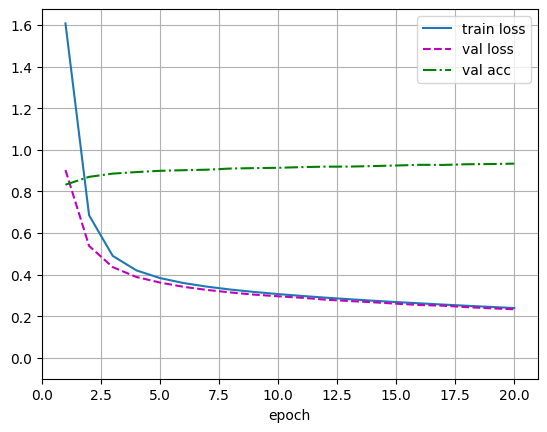

In [3]:
# 训练模型
num_epochs = epoch(20)
animator = ml.create_animator(xlabel='epoch', xlim=[0, epoch.totol_epoch + 1], ylim=-0.1, legend=['train loss', 'val loss', 'val acc'])  # 创建动画器
for current_epoch in range(1, num_epochs + 1):
    timer.start()  # 开始计时

    # 计算训练集
    metric_train = mltools.Accumulator(2)  # 累加器：(train_loss, train_size)
    model.train()  # 训练模式
    for x, y in train_iter:
        x = x.to(device)  # 转换x
        y = y.to(device)  # 转换y
        y_train = model(x)  # 计算模型
        train_loss = loss(y_train, y)  # 计算训练损失

        # 梯度更新
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        metric_train.add(train_loss * y.numel(), y.numel())
    recorder[0].append(metric_train[0] / metric_train[1])

    # 计算验证集
    metric_val = mltools.Accumulator(3)  # 累加器：(val_loss, val_acc, val_size)
    model.eval()  # 验证模式
    with torch.no_grad():
        for x, y in val_iter:
            x = x.to(device)  # 转换x
            y = y.to(device)  # 转换y
            y_val = model(x)  # 计算模型
            val_loss = loss(y_val, y)  # 计算验证损失
            val_pred = y_val.argmax(dim=1)  # 计算预测值
            val_acc = (val_pred == y).sum()  # 计算验证准确率
            metric_val.add(val_loss * y.numel(), val_acc, y.numel())
    recorder[1].append(metric_val[0] / metric_val[2])
    recorder[2].append(metric_val[1] / metric_val[2])

    timer.stop()  # 停止计时

    # 打印输出值
    ml.logger.info(f'train loss {recorder[0][-1]:.3f}, val loss {recorder[1][-1]:.3f}, val acc {recorder[2][-1]:.3f}')
    ml.print_training_time_massage(timer, num_epochs, current_epoch)
    ml.logger.info(f'trained on {str(device)}')
    animator.show(recorder.data)
else:
    # 打印输出值
    ml.logger.info(f'train loss {recorder[0][-1]:.3f}, val loss {recorder[1][-1]:.3f}, val acc {recorder[2][-1]:.3f}')
    ml.print_training_time_massage(timer, num_epochs, current_epoch)
    ml.logger.info(f'trained on {str(device)}')
    animator.show(recorder.data)
ml.save()

In [4]:
# 测试模型
model.eval()
metric = mltools.Accumulator(2)  # 累加器：(test_acc, test_size)
with torch.no_grad():
    for x, y in test_iter:
        x = x.to(device)  # 转换x
        y = y.to(device)  # 转换y
        y_test = model(x)  # 计算模型
        test_pred = y_test.argmax(dim=1)  # 计算准确率
        test_acc = (test_pred == y).sum()  # 计算测试准确率
        metric.add(test_acc, y.numel())
ml.logger.info(f'test acc {metric[0] / metric[1]:.3f}')  # 计算测试准确率并输出

2025-07-03 19:44:34,602 - INFO: test acc 0.933


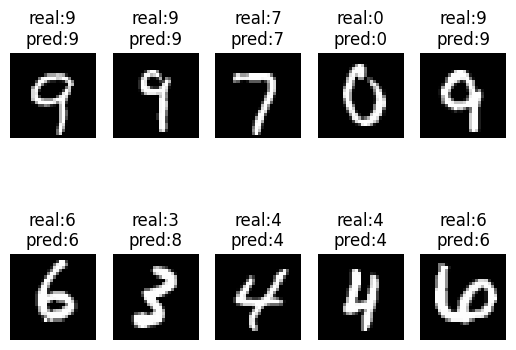

In [5]:
# 预测模型
model.eval()
x, y = next(iter(test_iter))  # 从测试中取一个批量
x = x[:10].to(device)
y = y[:10].to(device)
y_pred = model(x)  # 计算模型
y_pred = y_pred.argmax(dim=1)  # 计算预测
labels = [f'real:{y[index]}\npred:{y_pred[index]}' for index in range(y.numel())]
mltools.images(x.squeeze(1), labels, shape=(2, 5))